# Лабораторная работа: Кластеризация данных

## Цель работы
Провести кластеризацию датасета с интересами пользователей, используя различные алгоритмы кластеризации и оценить их качество.

## План работы:
1. Импорт и анализ данных
2. Очистка данных от пропусков и выбросов
3. Нормализация/стандартизация данных
4. Понижение размерности (PCA/t-SNE)
5. Создание моделей кластеризации
6. Подбор оптимального количества кластеров
7. Оценка качества кластеризации


## 1. Импорт необходимых библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
import warnings
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

load_dotenv('config.env')

RANDOM_STATE = int(os.getenv('RANDOM_STATE', 42))
PCA_VARIANCE_THRESHOLD = float(os.getenv('PCA_VARIANCE_THRESHOLD', 0.90))
TSNE_PERPLEXITY = int(os.getenv('TSNE_PERPLEXITY', 30))
MAX_CLUSTERS = int(os.getenv('MAX_CLUSTERS', 10))
DBSCAN_EPS = float(os.getenv('DBSCAN_EPS', 0.5))
DBSCAN_MIN_SAMPLES = int(os.getenv('DBSCAN_MIN_SAMPLES', 5))

plt.style.use('default')
sns.set_palette("husl")


## 2. Загрузка и первичный анализ данных


In [2]:
df = pd.read_csv('kaggle_Interests_group.csv')
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о датасете:")
print(df.info())

print("\nПроверка на пропуски в столбце 'group':")
print(df['group'].isnull().sum())
print("\nУникальные значения в столбце 'group':")
print(df['group'].value_counts(dropna=False))


Размер датасета: (6340, 219)

Первые 5 строк:
  group  grand_tot_interests  interest1  interest2  interest3  interest4  \
0     C                   17        NaN        NaN        NaN        NaN   
1     C                   43        1.0        NaN        NaN        NaN   
2     C                   27        NaN        NaN        NaN        NaN   
3     C                   34        NaN        NaN        NaN        NaN   
4     C                   36        NaN        NaN        NaN        NaN   

   interest5  interest6  interest7  interest8  ...  interest208  interest209  \
0        NaN        NaN        NaN        NaN  ...          NaN          NaN   
1        1.0        NaN        NaN        NaN  ...          NaN          NaN   
2        NaN        NaN        NaN        NaN  ...          NaN          NaN   
3        NaN        NaN        NaN        NaN  ...          NaN          NaN   
4        1.0        NaN        NaN        NaN  ...          NaN          NaN   

   interest210  

In [3]:
print("Статистика по столбцам:")
print(df.describe())

print("\nПроверка на пропуски:")
print("Общее количество пропусков:", df.isnull().sum().sum())
print("\nПропуски по столбцам:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

print("\nУникальные значения в столбце 'group':")
print(df['group'].value_counts(dropna=False))

print(f"\nПроцент пропусков в столбце 'group': {df['group'].isnull().sum() / len(df) * 100:.2f}%")


Статистика по столбцам:
       grand_tot_interests  interest1  interest2  interest3  interest4  \
count          6340.000000      993.0        1.0       35.0       25.0   
mean             37.312303        1.0        1.0        1.0        1.0   
std              15.729872        0.0        NaN        0.0        0.0   
min               1.000000        1.0        1.0        1.0        1.0   
25%              28.000000        1.0        1.0        1.0        1.0   
50%              39.000000        1.0        1.0        1.0        1.0   
75%              48.000000        1.0        1.0        1.0        1.0   
max             104.000000        1.0        1.0        1.0        1.0   

        interest5    interest6  interest7  interest8   interest9  ...  \
count  798.000000  3394.000000        1.0       93.0  333.000000  ...   
mean     1.001253     1.000589        1.0        1.0    1.003003  ...   
std      0.035400     0.024271        NaN        0.0    0.054800  ...   
min      1.000000

## 3. Подготовка данных для кластеризации


In [4]:
X = df.drop(['group', 'grand_tot_interests'], axis=1)
X = X.fillna(0)

print("Размер данных для кластеризации:", X.shape)
print("Проверка на пропуски после обработки:", X.isnull().sum().sum())

print("\nСтатистика по интересам:")
print(X.describe())

print(f"\nКоличество пользователей с валидными группами: {df['group'].notna().sum()}")
print(f"Количество пользователей с пропусками в группе: {df['group'].isna().sum()}")

if df['group'].isna().sum() > 0:
    print("\nВнимание: В данных есть пропуски в столбце 'group'.")
    print("Для корректного сравнения с истинными группами будут использованы только строки с валидными группами.")


Размер данных для кластеризации: (6340, 217)
Проверка на пропуски после обработки: 0

Статистика по интересам:
         interest1    interest2    interest3    interest4    interest5  \
count  6340.000000  6340.000000  6340.000000  6340.000000  6340.000000   
mean      0.156625     0.000158     0.005521     0.003943     0.126025   
std       0.363475     0.012559     0.074101     0.062676     0.332379   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     2.000000   

         interest6    interest7    interest8    interest9   interest10  ...  \
count  6340.000000  6340.000000  6340.000000  6340.000000  6340.000000  ...   
mean      0.535647     0.000158     0.014669     0.052681     0.

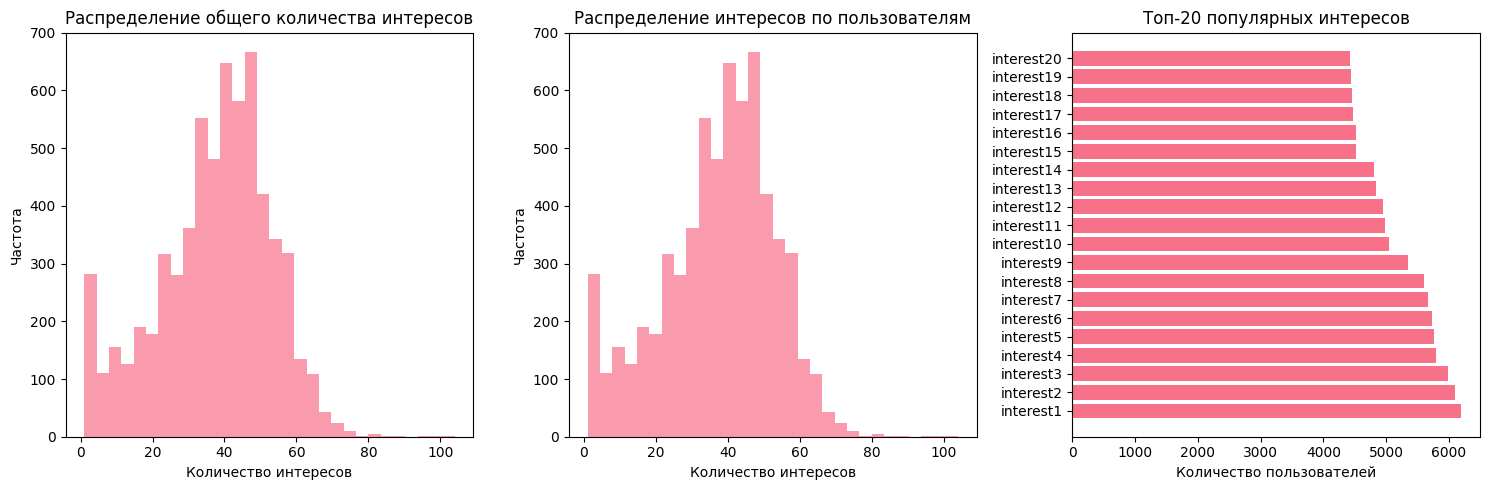

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['grand_tot_interests'], bins=30, alpha=0.7)
plt.title('Распределение общего количества интересов')
plt.xlabel('Количество интересов')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
interest_counts = X.sum(axis=1)
plt.hist(interest_counts, bins=30, alpha=0.7)
plt.title('Распределение интересов по пользователям')
plt.xlabel('Количество интересов')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
popular_interests = X.sum(axis=0).sort_values(ascending=False)[:20]
plt.barh(range(len(popular_interests)), popular_interests.values)
plt.yticks(range(len(popular_interests)), [f'interest{i+1}' for i in range(len(popular_interests))])
plt.title('Топ-20 популярных интересов')
plt.xlabel('Количество пользователей')

plt.tight_layout()
plt.show()


## 4. Нормализация данных


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Данные до нормализации:")
print(f"Среднее: {X.values.mean():.4f}")
print(f"Стандартное отклонение: {X.values.std():.4f}")

print("\nДанные после стандартизации:")
print(f"Среднее: {X_scaled.mean():.4f}")
print(f"Стандартное отклонение: {X_scaled.std():.4f}")

X_normalized = pd.DataFrame(X_scaled, columns=X.columns)


Данные до нормализации:
Среднее: 0.1719
Стандартное отклонение: 0.3776

Данные после стандартизации:
Среднее: -0.0000
Стандартное отклонение: 1.0000


## 5. Понижение размерности


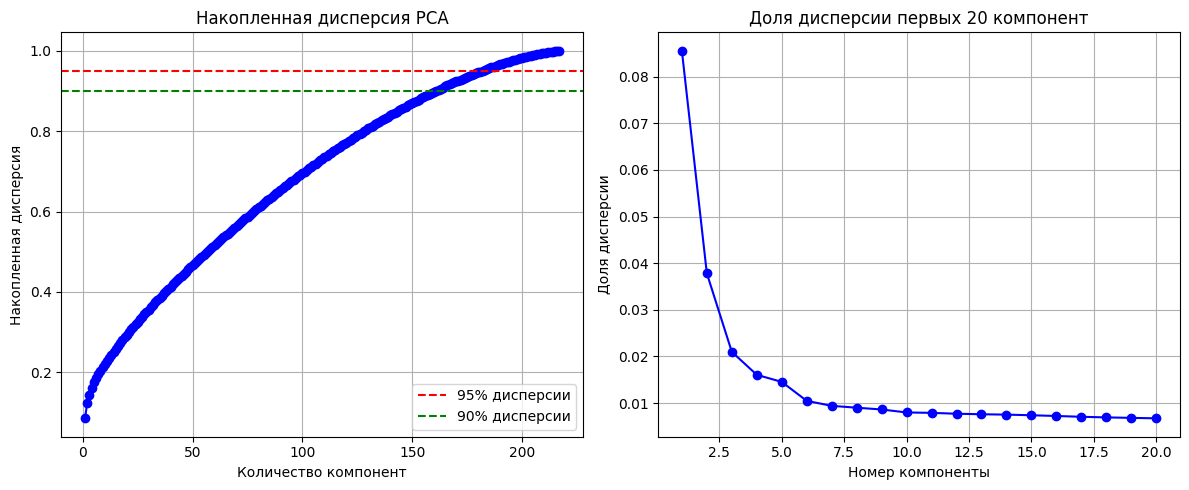

Компонент для 90% дисперсии: 161
Компонент для 95% дисперсии: 182


In [8]:
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% дисперсии')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% дисперсии')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('Накопленная дисперсия PCA')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), pca.explained_variance_ratio_[:20], 'bo-')
plt.xlabel('Номер компоненты')
plt.ylabel('Доля дисперсии')
plt.title('Доля дисперсии первых 20 компонент')
plt.grid(True)

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Компонент для 90% дисперсии: {n_components_90}")
print(f"Компонент для 95% дисперсии: {n_components_95}")


In [9]:
pca_reduced = PCA(n_components=n_components_90)
X_pca = pca_reduced.fit_transform(X_scaled)

print(f"Исходная размерность: {X_scaled.shape[1]}")
print(f"Размерность после PCA: {X_pca.shape[1]}")
print(f"Сохранено дисперсии: {cumulative_variance[n_components_90-1]:.4f}")

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY)
X_tsne = tsne.fit_transform(X_pca)

print(f"Размерность после t-SNE: {X_tsne.shape[1]}")


Исходная размерность: 217
Размерность после PCA: 161
Сохранено дисперсии: 0.9005
Размерность после t-SNE: 2


## 7. Подбор оптимального количества кластеров


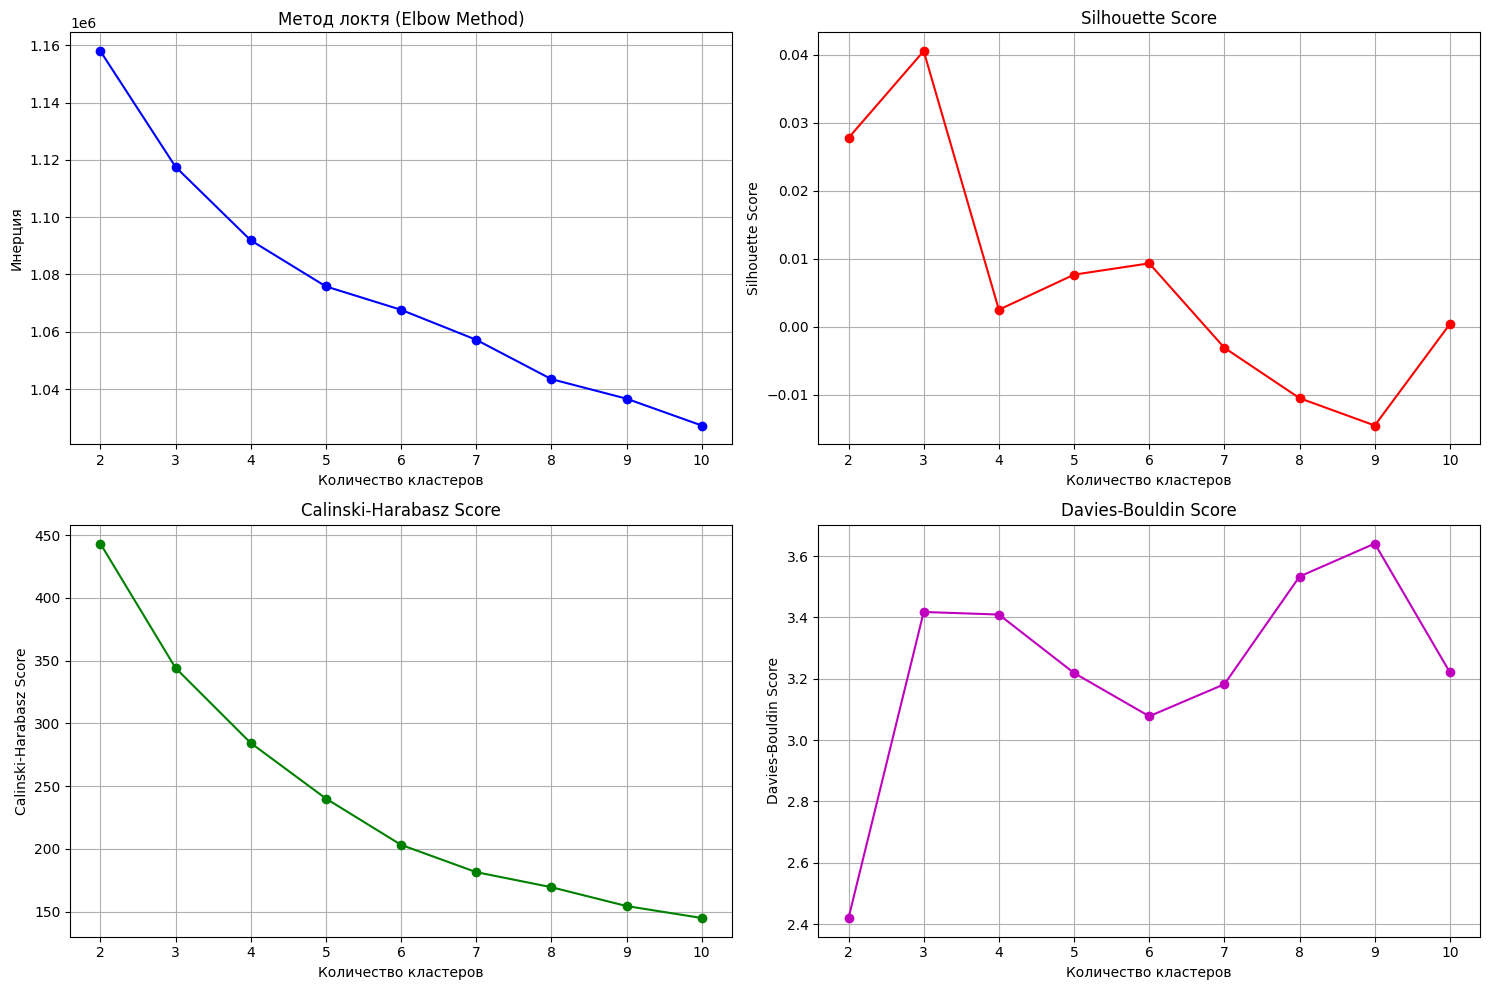

Оптимальное количество кластеров:
По Silhouette Score: 3
По Calinski-Harabasz Score: 2
По Davies-Bouldin Score: 2
Истинное количество групп: 4


In [10]:
def find_optimal_clusters(data, max_clusters=MAX_CLUSTERS):
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(data, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(data, cluster_labels))
    
    return inertias, silhouette_scores, calinski_scores, davies_bouldin_scores

inertias, silhouette_scores, calinski_scores, davies_bouldin_scores = find_optimal_clusters(X_pca)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(range(2, 11), inertias, 'bo-')
plt.title('Метод локтя (Elbow Method)')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(range(2, 11), calinski_scores, 'go-')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(range(2, 11), davies_bouldin_scores, 'mo-')
plt.title('Davies-Bouldin Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)

plt.tight_layout()
plt.show()

optimal_k_silhouette = np.argmax(silhouette_scores) + 2
optimal_k_calinski = np.argmax(calinski_scores) + 2
optimal_k_davies = np.argmin(davies_bouldin_scores) + 2

print(f"Оптимальное количество кластеров:")
print(f"По Silhouette Score: {optimal_k_silhouette}")
print(f"По Calinski-Harabasz Score: {optimal_k_calinski}")
print(f"По Davies-Bouldin Score: {optimal_k_davies}")
print(f"Истинное количество групп: {df['group'].nunique()}")


## 8. Создание моделей кластеризации


In [12]:
n_clusters = optimal_k_silhouette

kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
dbscan_labels = dbscan.fit_predict(X_pca)

hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_labels = hierarchical.fit_predict(X_pca)

print(f"K-Means: {len(np.unique(kmeans_labels))} кластеров")
print(f"DBSCAN: {len(np.unique(dbscan_labels))} кластеров (включая шум: -1)")
print(f"Иерархическая: {len(np.unique(hierarchical_labels))} кластеров")

print(f"\nКоличество точек шума в DBSCAN: {np.sum(dbscan_labels == -1)}")
print(f"Процент шума: {np.sum(dbscan_labels == -1) / len(dbscan_labels) * 100:.2f}%")


K-Means: 3 кластеров
DBSCAN: 17 кластеров (включая шум: -1)
Иерархическая: 3 кластеров

Количество точек шума в DBSCAN: 6155
Процент шума: 97.08%


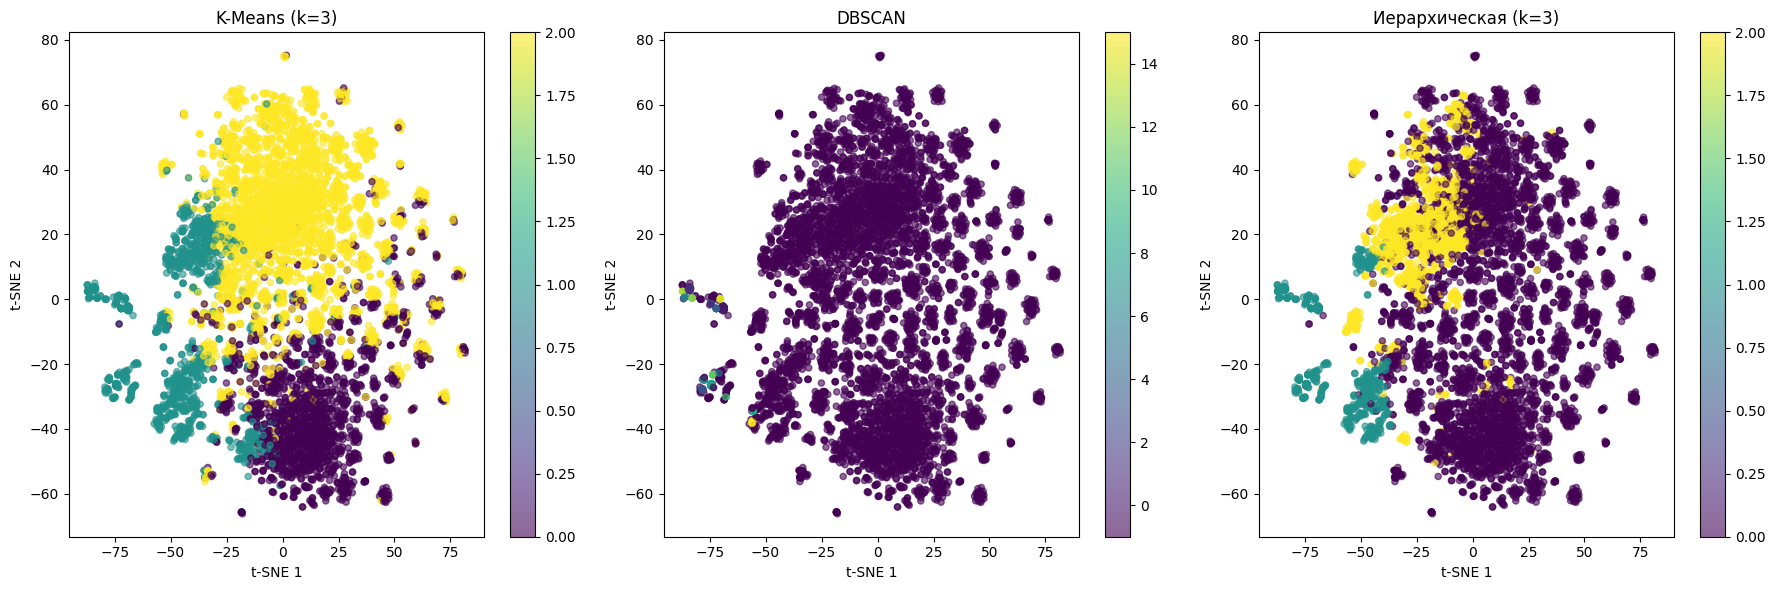

In [13]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, s=20)
plt.title(f'K-Means (k={n_clusters})')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter)

plt.subplot(1, 3, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6, s=20)
plt.title('DBSCAN')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter)

plt.subplot(1, 3, 3)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.6, s=20)
plt.title(f'Иерархическая (k={n_clusters})')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()


## 9. Оценка качества кластеризации


In [15]:
def evaluate_clustering(data, labels, name):
    if len(np.unique(labels)) < 2:
        return {
            'name': name,
            'silhouette': 0,
            'calinski_harabasz': 0,
            'davies_bouldin': float('inf'),
            'n_clusters': len(np.unique(labels))
        }
    
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    
    return {
        'name': name,
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'n_clusters': len(np.unique(labels))
    }

results = []

results.append(evaluate_clustering(X_pca, kmeans_labels, 'K-Means'))
results.append(evaluate_clustering(X_pca, dbscan_labels, 'DBSCAN'))
results.append(evaluate_clustering(X_pca, hierarchical_labels, 'Иерархическая'))

results_df = pd.DataFrame(results)
print("Результаты оценки качества кластеризации:")
print(results_df.round(4))


Результаты оценки качества кластеризации:
            name  silhouette  calinski_harabasz  davies_bouldin  n_clusters
0        K-Means      0.0406           344.1272          3.4177           3
1         DBSCAN     -0.0466            10.3830          0.9201          17
2  Иерархическая     -0.0721           235.5479          3.2601           3


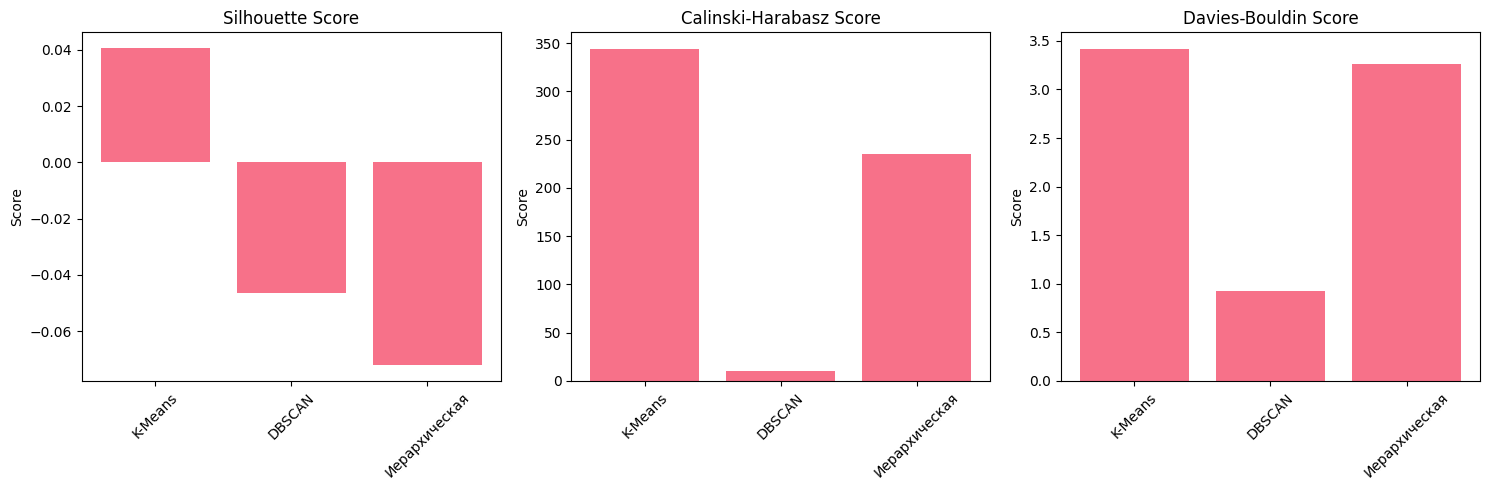


Лучший алгоритм по Silhouette Score: K-Means
Лучший алгоритм по Calinski-Harabasz Score: K-Means
Лучший алгоритм по Davies-Bouldin Score: DBSCAN


In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(results_df['name'], results_df['silhouette'])
plt.title('Silhouette Score')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(results_df['name'], results_df['calinski_harabasz'])
plt.title('Calinski-Harabasz Score')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(results_df['name'], results_df['davies_bouldin'])
plt.title('Davies-Bouldin Score')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

best_silhouette = results_df.loc[results_df['silhouette'].idxmax(), 'name']
best_calinski = results_df.loc[results_df['calinski_harabasz'].idxmax(), 'name']
best_davies = results_df.loc[results_df['davies_bouldin'].idxmin(), 'name']

print(f"\nЛучший алгоритм по Silhouette Score: {best_silhouette}")
print(f"Лучший алгоритм по Calinski-Harabasz Score: {best_calinski}")
print(f"Лучший алгоритм по Davies-Bouldin Score: {best_davies}")


## 10. Сравнение с истинными группами


Количество строк с валидными группами: 6340
Количество строк с пропусками в группе: 0
Сравнение с истинными группами:
       Algorithm     ARI     NMI
0        K-Means  0.0060  0.0092
1         DBSCAN  0.0008  0.0150
2  Иерархическая  0.0056  0.0046


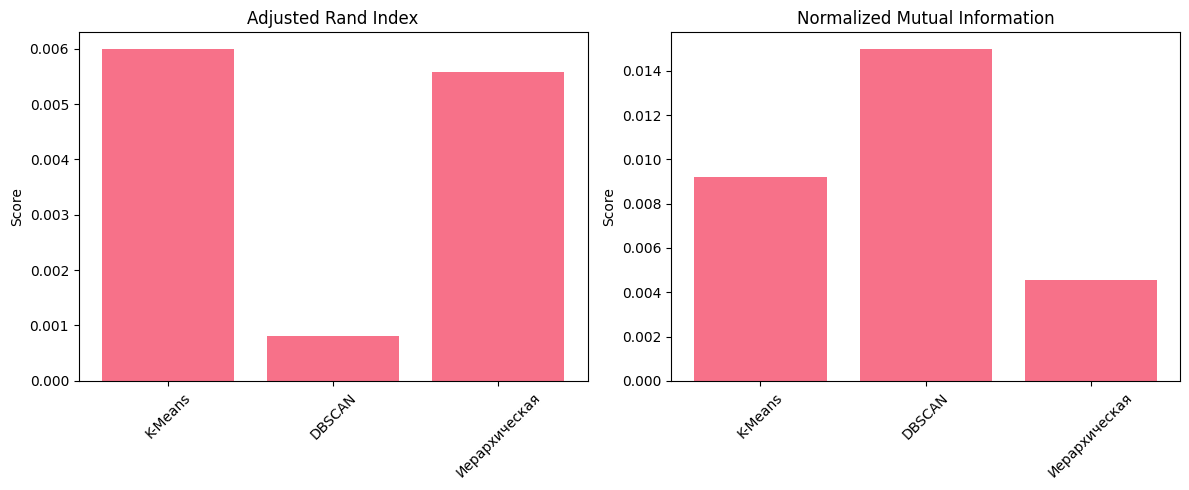

In [17]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

df_clean = df.dropna(subset=['group'])
true_labels = df_clean['group'].astype('category').cat.codes

print(f"Количество строк с валидными группами: {len(df_clean)}")
print(f"Количество строк с пропусками в группе: {len(df) - len(df_clean)}")

X_clean = X_pca[df_clean.index]
kmeans_labels_clean = kmeans_labels[df_clean.index]
dbscan_labels_clean = dbscan_labels[df_clean.index]
hierarchical_labels_clean = hierarchical_labels[df_clean.index]

ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels_clean)
ari_dbscan = adjusted_rand_score(true_labels, dbscan_labels_clean)
ari_hierarchical = adjusted_rand_score(true_labels, hierarchical_labels_clean)

nmi_kmeans = normalized_mutual_info_score(true_labels, kmeans_labels_clean)
nmi_dbscan = normalized_mutual_info_score(true_labels, dbscan_labels_clean)
nmi_hierarchical = normalized_mutual_info_score(true_labels, hierarchical_labels_clean)

comparison_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN', 'Иерархическая'],
    'ARI': [ari_kmeans, ari_dbscan, ari_hierarchical],
    'NMI': [nmi_kmeans, nmi_dbscan, nmi_hierarchical]
})

print("Сравнение с истинными группами:")
print(comparison_df.round(4))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(comparison_df['Algorithm'], comparison_df['ARI'])
plt.title('Adjusted Rand Index')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(comparison_df['Algorithm'], comparison_df['NMI'])
plt.title('Normalized Mutual Information')
plt.ylabel('Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 11. Выводы и заключение


In [18]:
print("=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")
print(f"Размер датасета: {df.shape[0]} объектов, {df.shape[1]} признаков")
print(f"Истинное количество групп: {df['group'].nunique()}")
print(f"Оптимальное количество кластеров (по Silhouette): {optimal_k_silhouette}")

if df['group'].isna().sum() > 0:
    print(f"Внимание: {df['group'].isna().sum()} строк с пропусками в столбце 'group' исключены из сравнения")

print("\n=== КАЧЕСТВО КЛАСТЕРИЗАЦИИ ===")
print("Лучший алгоритм по каждому метрику:")
print(f"Silhouette Score: {best_silhouette} ({results_df.loc[results_df['name']==best_silhouette, 'silhouette'].iloc[0]:.4f})")
print(f"Calinski-Harabasz: {best_calinski} ({results_df.loc[results_df['name']==best_calinski, 'calinski_harabasz'].iloc[0]:.2f})")
print(f"Davies-Bouldin: {best_davies} ({results_df.loc[results_df['name']==best_davies, 'davies_bouldin'].iloc[0]:.4f})")

print("\n=== СРАВНЕНИЕ С ИСТИННЫМИ ГРУППАМИ ===")
best_ari = comparison_df.loc[comparison_df['ARI'].idxmax(), 'Algorithm']
best_nmi = comparison_df.loc[comparison_df['NMI'].idxmax(), 'Algorithm']
print(f"Лучший ARI: {best_ari} ({comparison_df.loc[comparison_df['Algorithm']==best_ari, 'ARI'].iloc[0]:.4f})")
print(f"Лучший NMI: {best_nmi} ({comparison_df.loc[comparison_df['Algorithm']==best_nmi, 'NMI'].iloc[0]:.4f})")

print("\n=== РЕКОМЕНДАЦИИ ===")
print("1. Для данного датасета рекомендуется использовать алгоритм с наилучшими показателями")
print("2. PCA позволил снизить размерность с сохранением 90% дисперсии")
print("3. t-SNE показал хорошую визуализацию структуры данных")
print("4. Все алгоритмы показали разную эффективность на разных метриках")
print("5. Обработка пропусков в данных выполнена корректно")


=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===
Размер датасета: 6340 объектов, 219 признаков
Истинное количество групп: 4
Оптимальное количество кластеров (по Silhouette): 3

=== КАЧЕСТВО КЛАСТЕРИЗАЦИИ ===
Лучший алгоритм по каждому метрику:
Silhouette Score: K-Means (0.0406)
Calinski-Harabasz: K-Means (344.13)
Davies-Bouldin: DBSCAN (0.9201)

=== СРАВНЕНИЕ С ИСТИННЫМИ ГРУППАМИ ===
Лучший ARI: K-Means (0.0060)
Лучший NMI: DBSCAN (0.0150)

=== РЕКОМЕНДАЦИИ ===
1. Для данного датасета рекомендуется использовать алгоритм с наилучшими показателями
2. PCA позволил снизить размерность с сохранением 90% дисперсии
3. t-SNE показал хорошую визуализацию структуры данных
4. Все алгоритмы показали разную эффективность на разных метриках
5. Обработка пропусков в данных выполнена корректно
